In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.covariance import OAS, LedoitWolf
from scipy.stats import mode

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
#import seaborn as sns

import plotly.graph_objects as go

In [2]:
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
orders_df = pd.read_csv("orders.csv")
products_df = pd.read_csv("products.csv")
aisles_df = pd.read_csv("aisles.csv")
departments_df = pd.read_csv("departments.csv")

In [3]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
products_df.shape

(49688, 4)

In [5]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
data = pd.merge(order_products_prior_df, orders_df, on=["order_id", "order_id"])
#data = pd.merge(data, products_df, on=["product_id", "product_id"])
#data = pd.merge(data, aisles_df, on=["aisle_id", "aisle_id"])
#data = pd.merge(data, departments_df, on=["department_id", "department_id"])

In [11]:
train_data = pd.merge(order_products_train_df, orders_df, on=["order_id", "order_id"])
train_data = pd.merge(train_data, products_df, on=["product_id", "product_id"])
train_data = pd.merge(train_data, aisles_df, on=["aisle_id", "aisle_id"])
train_data = pd.merge(train_data, departments_df, on=["department_id", "department_id"])

In [12]:
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [13]:
grouped = data.groupby("order_id")["add_to_cart_order"].aggregate(products_per_order = 'max').reset_index()
grouped = pd.merge(grouped, data[["order_id", "order_dow", "order_hour_of_day", "days_since_prior_order", "user_id"]], how='left', on=["order_id"])
grouped.drop_duplicates(inplace=True)
grouped.head()

,order_id,products_per_order,order_dow,order_hour_of_day,days_since_prior_order,user_id
0,2,9,5,9,8.0,202279
9,3,8,5,17,12.0,205970
17,4,13,1,9,7.0,178520
30,5,26,6,16,9.0,156122
56,6,3,1,12,30.0,22352


In [14]:
data = pd.merge(data, products_df, on=["product_id", "product_id"])

In [15]:
data = pd.merge(data, departments_df, on=["department_id", "department_id"])

In [42]:
data = pd.merge(data, aisles_df, on='aisle_id')

In [43]:
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,dairy eggs,eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,dairy eggs,eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,dairy eggs,eggs


In [133]:
c = pd.pivot_table(data, values=['order_id'], index=['user_id'], 
                   columns=['department_id'], aggfunc='count', fill_value=0)

In [135]:
c.columns = c.columns.droplevel()
c.columns.name = None
c.columns = list(departments_df['department'])
c

,frozen,other,bakery,produce,alcohol,international,beverages,pets,dry goods pasta,bulk,...,meat seafood,pantry,breakfast,canned goods,dairy eggs,household,babies,snacks,deli,missing
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,5,0,0,13,0,0,0,...,0,1,3,0,13,2,0,22,0,0
2,17,0,2,36,0,3,9,0,0,0,...,1,11,3,1,48,0,0,42,21,0
3,6,0,0,38,0,0,3,0,4,0,...,0,4,0,0,21,1,0,9,2,0
4,3,0,2,2,2,0,3,0,0,0,...,0,0,0,1,0,2,0,1,2,0
5,2,0,0,19,0,2,0,0,1,0,...,0,2,0,1,8,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,2,0,2,7,0,0,1,0,0,0,...,1,0,0,0,14,0,1,0,3,1
206206,76,1,2,34,0,4,33,0,1,0,...,2,14,1,9,39,12,0,42,5,0
206207,21,0,3,50,0,1,20,0,8,0,...,6,15,4,11,52,0,1,23,8,0


/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Ma

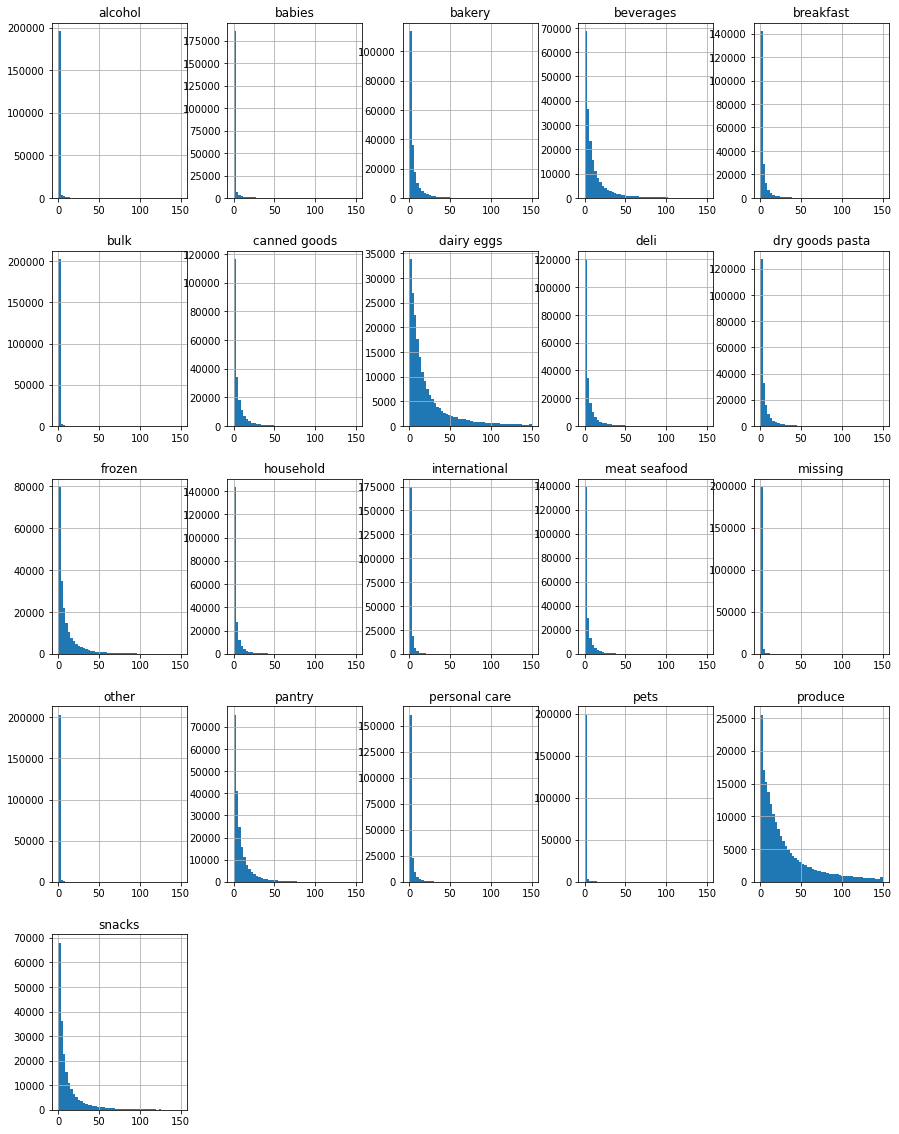

In [148]:
c.hist(figsize=(15, 20), bins=50, range=(0, 150))
plt.show()

In [136]:
X = c.to_numpy()

In [137]:
cov = LedoitWolf().fit(X).covariance_
#cov = np.cov(X, rowvar=False)
icov = np.linalg.inv(cov)

print('condition number: ', np.linalg.cond(cov))
print('global variance: ', np.linalg.det(cov))

cor = c.corr().to_numpy()

Det = np.linalg.det(cor)
f = (len(cor)-1)
D = 1 - Det**(1/f)
print('Coeficiente de dependencia: ', D)

r2 = 1 - 1/(np.diag(cov) * np.diag(icov))
#print(r2)
print('max: ', c.columns[np.argmax(r2)], 'r2: ', np.max(r2))



condition number:  6744.6566471252
global variance:  3.641290441801327e+35
Coeficiente de dependencia:  0.30991242982710254
max:  dairy eggs r2:  0.6629510616391966


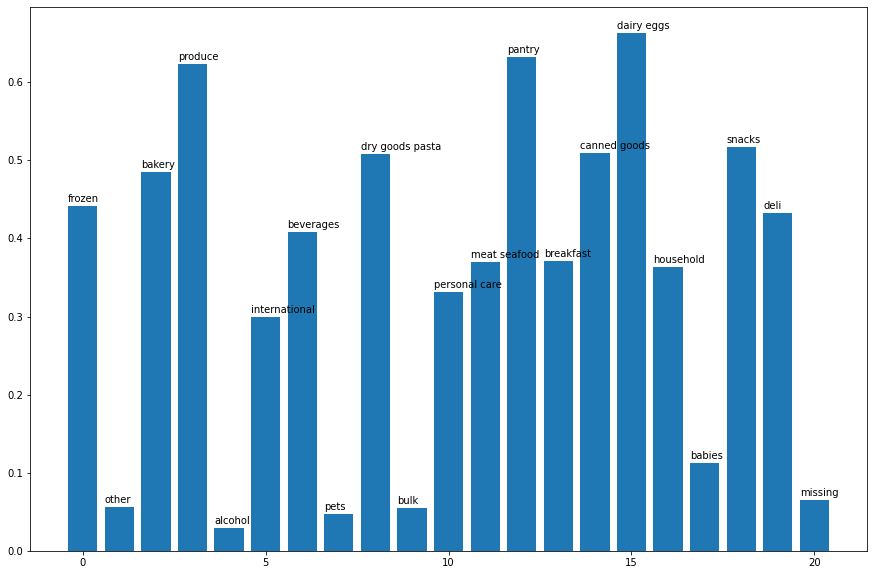

In [143]:
plt.figure(figsize=(15, 10))
bars = plt.bar(np.arange(len(r2)), r2)

top10 = np.argsort(r2)[-20:]

for i, bar in enumerate(bars):
    #if i in top10:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, c.columns[i])
    

plt.show()

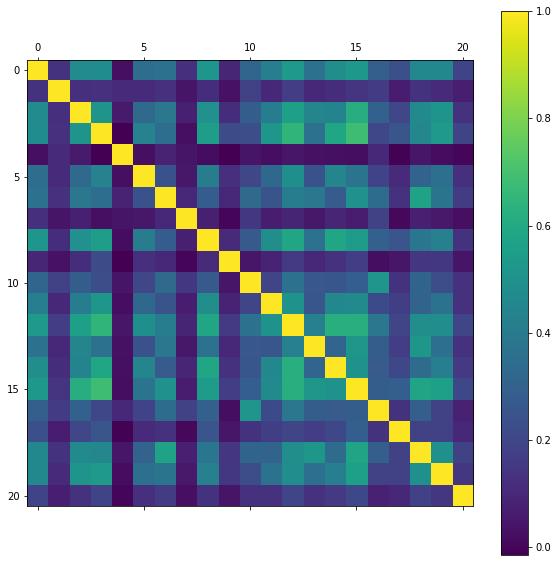

In [146]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(cor)
fig.colorbar(cax)
plt.show()

In [114]:
ax.matshow?

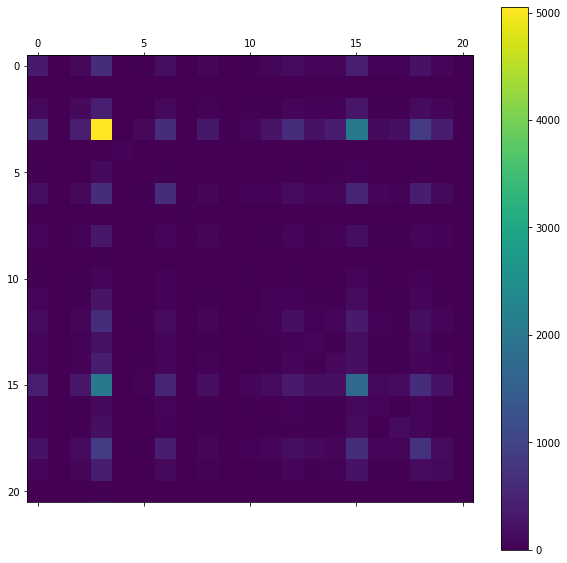

In [145]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(cov)
fig.colorbar(cax)
plt.show()

In [149]:
c = pd.pivot_table(data, values=['order_id'], index=['user_id'], 
                   columns=['aisle_id'], aggfunc='count', fill_value=0)

In [150]:
c.columns = c.columns.droplevel()
c.columns.name = None
c.columns = list(aisles_df['aisle'])
c

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206206,0,3,7,1,0,1,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
206207,0,0,6,0,0,0,2,0,6,0,...,1,0,0,2,0,3,1,0,0,0


In [153]:
X = c.to_numpy()

In [154]:
cov = LedoitWolf().fit(X).covariance_
#cov = np.cov(X, rowvar=False)
icov = np.linalg.inv(cov)

print('condition number: ', np.linalg.cond(cov))
print('global variance: ', np.linalg.det(cov))

cor = c.corr().to_numpy()

Det = np.linalg.det(cor)
f = (len(cor)-1)
D = 1 - Det**(1/f)
print('Coeficiente de dependencia: ', D)

r2 = 1 - 1/(np.diag(cov) * np.diag(icov))
#print(r2)
print('max: ', c.columns[np.argmax(r2)], 'r2: ', np.max(r2))



condition number:  25135.52335330437
global variance:  3.7315893646981994e+73
Coeficiente de dependencia:  0.1847078727771878
max:  fresh vegetables r2:  0.7392349856446195


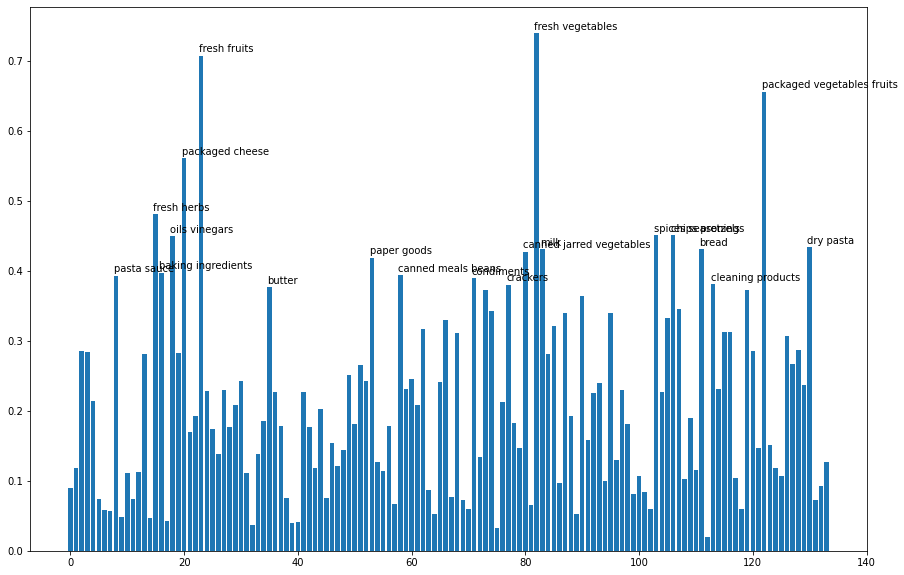

In [155]:
plt.figure(figsize=(15, 10))
bars = plt.bar(np.arange(len(r2)), r2)

top10 = np.argsort(r2)[-20:]

for i, bar in enumerate(bars):
    if i in top10:
        yval = bar.get_height()
        plt.text(bar.get_x(), yval + .005, c.columns[i])

plt.show()

In [104]:
cor['fresh vegetables'].sort_values(ascending=False).head(10)

fresh vegetables              1.000000
fresh fruits                  0.684919
packaged vegetables fruits    0.678326
fresh herbs                   0.654220
oils vinegars                 0.538049
canned jarred vegetables      0.525619
spices seasonings             0.517452
grains rice dried goods       0.487051
packaged cheese               0.475306
canned meals beans            0.456924
Name: fresh vegetables, dtype: float64

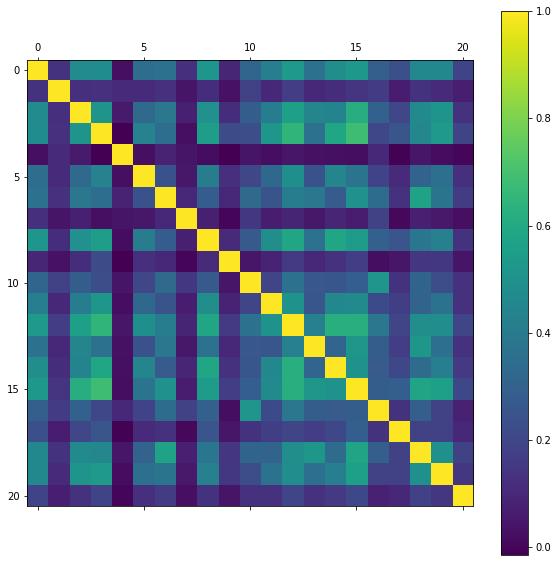

In [146]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(cor)
fig.colorbar(cax)
plt.show()

In [114]:
ax.matshow?

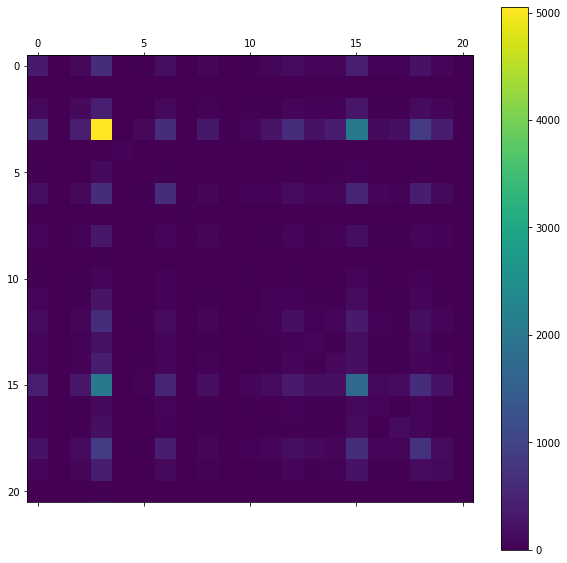

In [145]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(cov)
fig.colorbar(cax)
plt.show()

In [75]:
x = c.iloc[:, c.columns != 'fresh vegetables']
y = c['fresh vegetables']

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

models = {'Linear': LinearRegression(), 'Ridge': Ridge(), 'Lasso': Lasso(), 'Elastic': ElasticNet()}
results = pd.DataFrame(columns=['Model', 'Train R2', 'Test R2', '# Params'])

for model in models.keys():
    model_results = {}
    clf = models[model].fit(x_train, y_train)
    model_results['Model'] = model
    model_results['Train R2'] = clf.score(x_train, y_train)
    model_results['Test R2'] = clf.score(x_test, y_test)
    model_results['# Params'] = np.sum(clf.coef_ != 0)
    results = results.append(model_results, ignore_index=True)
    
results

,Model,Train R2,Test R2,# Params
0,Linear,0.740932,0.731464,133
1,Ridge,0.740932,0.731464,133
2,Lasso,0.733220,0.723949,54
3,Elastic,0.736440,0.727093,71


In [164]:
x.columns[np.argsort(clf.coef_) != 0]

Index(['prepared soups salads', 'specialty cheeses', 'energy granola bars',
       'instant foods', 'marinades meat preparation', 'other', 'packaged meat',
       'bakery desserts', 'pasta sauce', 'kitchen supplies',
       ...
       'trail mix snack mix', 'feminine care', 'body lotions soap',
       'tortillas flat bread', 'frozen appetizers sides',
       'hot cereal pancake mixes', 'dry pasta', 'beauty',
       'muscles joints pain relief', 'specialty wines champagnes'],
      dtype='object', length=132)

In [197]:
non_zero_index = np.where(clf.coef_ != 0)[0]
non_zero_vars = x.columns[non_zero_index]
non_zero_vals = clf.coef_[non_zero_index]
ordered_index = np.flip(np.argsort(non_zero_vals))
dict(zip(list(non_zero_vars[ordered_index]), list(non_zero_vals[ordered_index])))

{'fresh herbs': 1.5761808631578627,
 'grains rice dried goods': 0.9345221362255276,
 'oils vinegars': 0.7208791380913167,
 'canned jarred vegetables': 0.6785465498334853,
 'meat counter': 0.6760754741004801,
 'poultry counter': 0.6026518813374828,
 'seafood counter': 0.54458384783037,
 'spices seasonings': 0.47635715244316745,
 'tofu meat alternatives': 0.42310927110006086,
 'canned meals beans': 0.3553327304667675,
 'packaged vegetables fruits': 0.3366186098861134,
 'fresh fruits': 0.3012762893706071,
 'butter': 0.29944498924734664,
 'eggs': 0.281273824768218,
 'asian foods': 0.2773922997589251,
 'soup broth bouillon': 0.22929119556610264,
 'dry pasta': 0.195121036495169,
 'pickled goods olives': 0.16879789901691927,
 'condiments': 0.16086051443218397,
 'pasta sauce': 0.15748508990899088,
 'canned meat seafood': 0.13133616408409407,
 'bulk grains rice dried goods': 0.08915945681909532,
 'tortillas flat bread': 0.0844460752927546,
 'frozen produce': 0.07109769202879822,
 'other creams 

In [209]:
zero_index = np.where(clf.coef_ == 0)[0]
zero_vars = x.columns[zero_index]
zero_vals = clf.coef_[zero_index]
ordered_index = np.flip(np.argsort(zero_vals))
dict(zip(list(zero_vars[ordered_index]), list(zero_vals[ordered_index])))

{'specialty wines champagnes': -0.0,
 'latino foods': 0.0,
 'white wines': -0.0,
 'trash bags liners': -0.0,
 'frozen breads doughs': 0.0,
 'diapers wipes': -0.0,
 'shave needs': -0.0,
 'preserved dips spreads': 0.0,
 'vitamins supplements': 0.0,
 'mint gum': -0.0,
 'candy chocolate': -0.0,
 'eye ear care': -0.0,
 'frozen vegan vegetarian': 0.0,
 'dog food care': -0.0,
 'kosher foods': 0.0,
 'honeys syrups nectars': -0.0,
 'muscles joints pain relief': -0.0,
 'red wines': -0.0,
 'beers coolers': -0.0,
 'soap': 0.0,
 'hair care': -0.0,
 'oral hygiene': -0.0,
 'bulk dried fruits vegetables': 0.0,
 'packaged seafood': 0.0,
 'fresh pasta': -0.0,
 'cold flu allergy': -0.0,
 'kitchen supplies': -0.0,
 'bakery desserts': -0.0,
 'other': -0.0,
 'marinades meat preparation': 0.0,
 'protein meal replacements': -0.0,
 'fresh dips tapenades': 0.0,
 'digestion': 0.0,
 'refrigerated pudding desserts': -0.0,
 'beauty': -0.0,
 'hot cereal pancake mixes': -0.0,
 'feminine care': -0.0,
 'trail mix snack

For n_clusters = 2 The average silhouette_score is : 0.7098768215539836
For n_clusters = 3 The average silhouette_score is : 0.5832411556744115
For n_clusters = 4 The average silhouette_score is : 0.47919955854193846
For n_clusters = 5 The average silhouette_score is : 0.4720954827925637
For n_clusters = 6 The average silhouette_score is : 0.4140880626652216


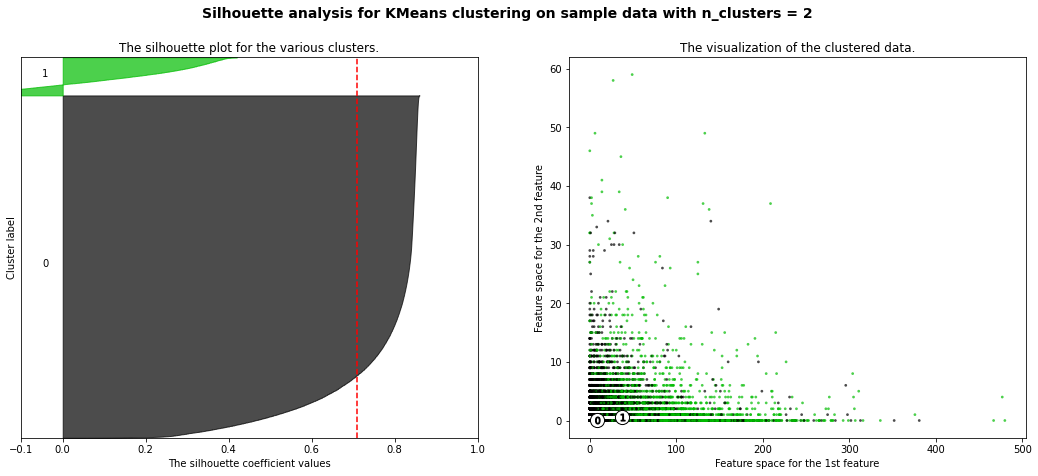

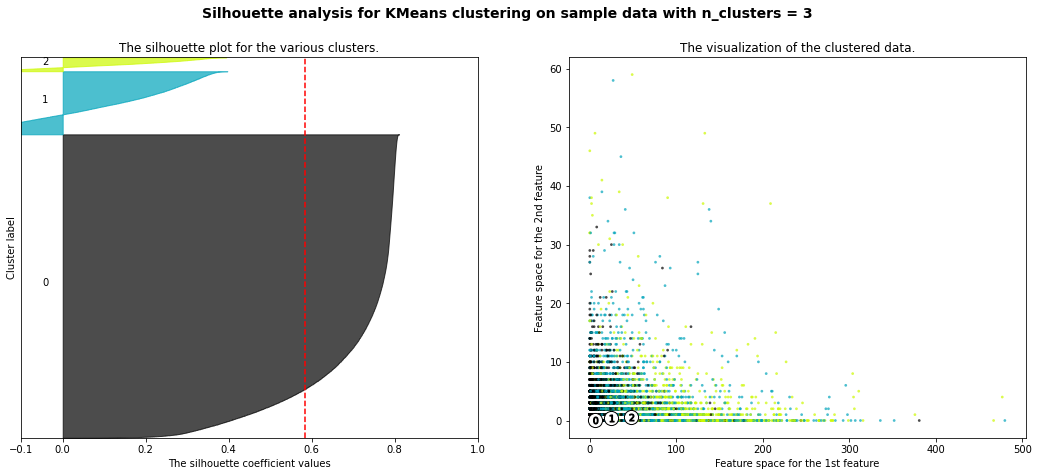

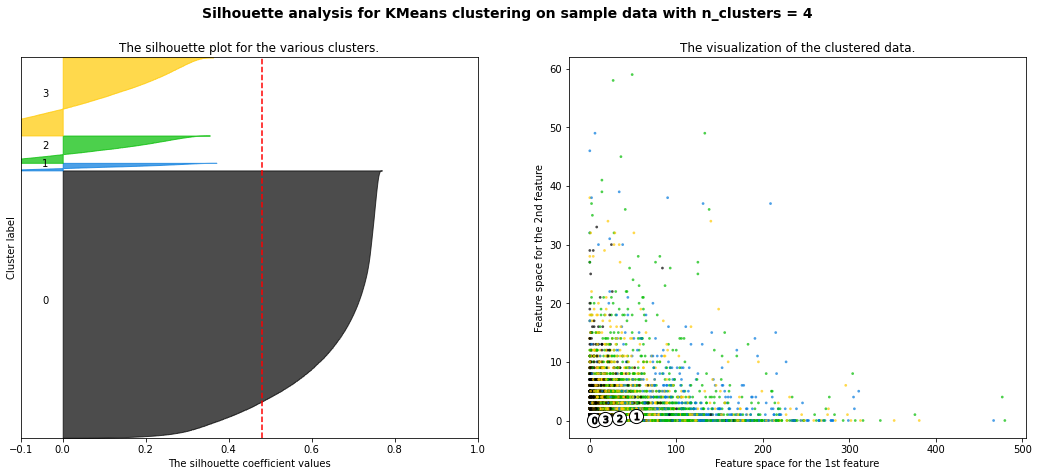

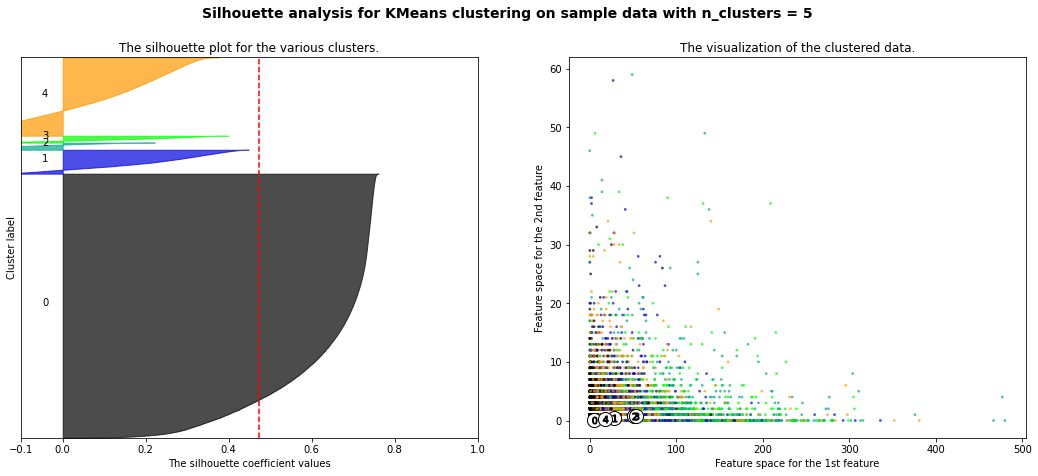

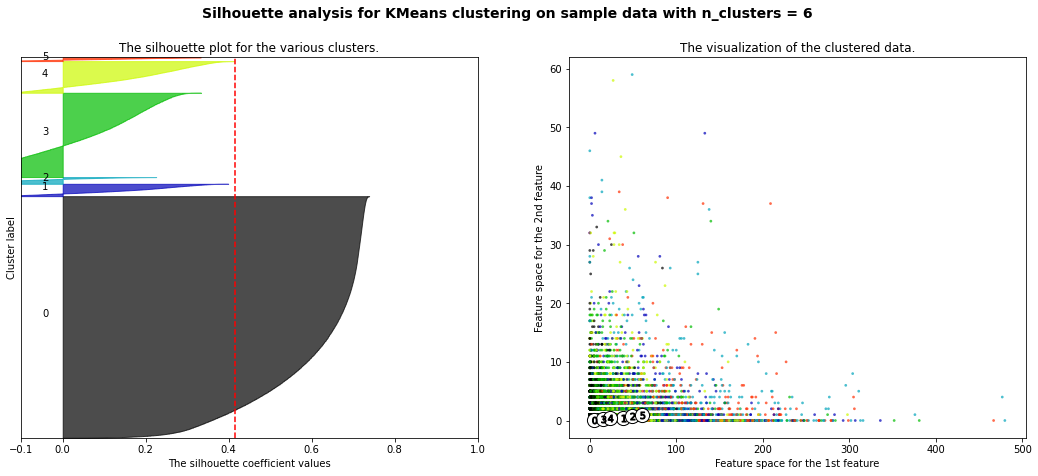

In [41]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [65]:
kmeans = KMeans(n_clusters=4).fit(X)
clusters = kmeans.predict(X)

In [201]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X)

In [202]:
pca.explained_variance_ratio_

array([0.48237998, 0.09585824])

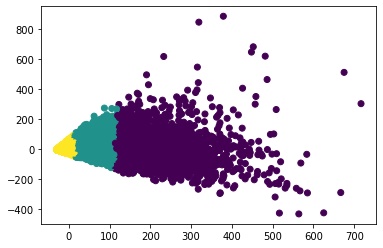

In [203]:
plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters)
plt.show()

In [204]:
pca = PCA(n_components=3)
reduced = pca.fit_transform(X)

In [205]:
pca.explained_variance_ratio_

array([0.48237998, 0.09585824, 0.05185877])

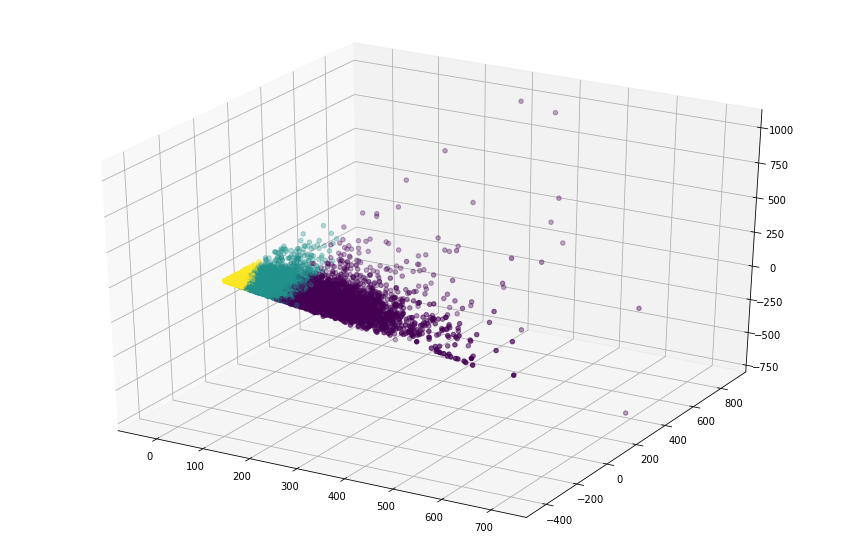

In [206]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=clusters)
plt.show()